In [1]:
# Imports
import numpy as np
import pandas as pd
from functions import *
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import *
from tensorflow.keras.models import *

In [2]:
# Carregando o conjunto de dados de treinamento e teste
dataset_train = get_train()
dataset_test = get_test()

In [3]:
# Dataset de treinamento
dataset_train

,Filepath,Label
0,..\images\train\F\F1.png,F
1,..\images\train\F\F10.png,F
2,..\images\train\F\F100.png,F
3,..\images\train\F\F101.png,F
4,..\images\train\F\F102.png,F
...,...,...
99194,..\images\train\V\V995.png,V
99195,..\images\train\V\V996.png,V
99196,..\images\train\V\V997.png,V
99197,..\images\train\V\V998.png,V


In [4]:
# Dataset de teste
dataset_test

,Filepath,Label
0,..\images\test\F\F0.png,F
1,..\images\test\F\F104.png,F
2,..\images\test\F\F113.png,F
3,..\images\test\F\F115.png,F
4,..\images\test\F\F118.png,F
...,...,...
24794,..\images\test\V\V98.png,V
24795,..\images\test\V\V981.png,V
24796,..\images\test\V\V986.png,V
24797,..\images\test\V\V987.png,V


In [5]:
# Quantas instâncias existem para cada label de treinamento
print(dataset_train['Label'].value_counts())

Label
N    75709
M     8405
Q     6431
V     5789
S     2223
F      642
Name: count, dtype: int64


In [6]:
# Quantas instâncias existem para cada label de teste
print(dataset_test['Label'].value_counts())

Label
N    18926
M     2101
Q     1608
V     1447
S      556
F      161
Name: count, dtype: int64


In [7]:
# Balanceamento dos dados de treinamento

samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataset_train.query("Label == @category")
    samples.append(category_slice.sample(640, random_state=1))

dataframe_train = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_train['Label'].value_counts()

Label
N    640
Q    640
S    640
F    640
M    640
V    640
Name: count, dtype: int64

In [8]:
# Balanceamento dos dados de teste

samples = []
for category in ['N','M','Q','V','S','F']:
    category_slice = dataset_test.query("Label == @category")
    samples.append(category_slice.sample(160, random_state=1))

dataframe_test = pd.concat(samples, axis=0).sample(frac=1.0, random_state=1).reset_index(drop=True)
dataframe_test['Label'].value_counts()

Label
M    160
F    160
Q    160
N    160
V    160
S    160
Name: count, dtype: int64

In [9]:
# Dataset de treinamento agora balanceado
dataframe_train

,Filepath,Label
0,..\images\train\N\N80645.png,N
1,..\images\train\Q\Q644.png,Q
2,..\images\train\S\S2383.png,S
3,..\images\train\S\S2269.png,S
4,..\images\train\F\F138.png,F
...,...,...
3835,..\images\train\S\S1594.png,S
3836,..\images\train\M\M5641.png,M
3837,..\images\train\M\M8804.png,M
3838,..\images\train\N\N46498.png,N


In [10]:
# Dataset de teste agora balanceado
dataframe_test

,Filepath,Label
0,..\images\test\M\M933.png,M
1,..\images\test\F\F377.png,F
2,..\images\test\Q\Q6746.png,Q
3,..\images\test\Q\Q883.png,Q
4,..\images\test\Q\Q6569.png,Q
...,...,...
955,..\images\test\S\S1979.png,S
956,..\images\test\N\N26059.png,N
957,..\images\test\F\F418.png,F
958,..\images\test\M\M971.png,M


In [11]:
def rgb_to_gray(image):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    image = cv2.merge((image,image,image))
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=rgb_to_gray,
    rescale=1./255,
    validation_split=0.2
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function=rgb_to_gray,
    rescale=1./255
)

In [13]:
size=224
color_mode='rgb'
batch_size=32

train_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_dataframe(
    dataframe=dataframe_train,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_dataframe(
    dataframe=dataframe_test,
    x_col='Filepath',
    y_col='Label',
    target_size=(size, size),
    color_mode=color_mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)

Found 3072 validated image filenames belonging to 6 classes.
Found 768 validated image filenames belonging to 6 classes.
Found 960 validated image filenames belonging to 6 classes.


In [15]:
test_images.class_indices

{'F': 0, 'M': 1, 'N': 2, 'Q': 3, 'S': 4, 'V': 5}

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


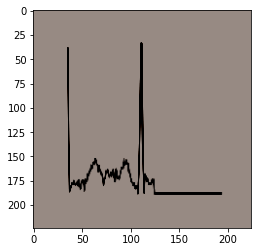

In [16]:
plt.imshow(test_images[0][0][0], cmap='gray')

In [17]:
# Modelando por meio da ResNet50
pretrained_model = ResNet50(
                              input_shape=(224,224,3),
                              include_top= False,
                              weights='imagenet',
                              pooling='avg'
                              )

pretrained_model.trainable = False

In [18]:
model = Sequential ([
                        pretrained_model,
                        Flatten(),
                        Dropout(0.2),
                        Dense(128, activation='relu'),
                        Dense(64, activation='relu'),
                        Dense(6, activation='softmax')
                    ])


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 23,858,630
Trainable params: 270,918
Non-t

In [19]:
import keras
checkpoint = keras.callbacks.ModelCheckpoint(
    filepath='best_model2.h5',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1)

In [20]:
model.compile(loss='categorical_crossentropy', optimizer='adam',
              metrics=['accuracy',
                       'Precision',
                       'Recall',
                       tf.keras.metrics.AUC(
                           num_thresholds=200,
                           curve="ROC",
                           summation_method="interpolation",
                           multi_label=False
                       )])


In [21]:
result=model.fit(
    train_images,
    steps_per_epoch=3072//32,
    validation_data=val_images,
    validation_steps=768//32,
    epochs=10,
    callbacks=[checkpoint]
)

Epoch 1/10
96/96 [==============================] - ETA: 0s - loss: 1.3136 - accuracy: 0.4388 - precision: 0.7208 - recall: 0.1185 - auc: 0.8268
Epoch 1: val_accuracy improved from -inf to 0.80078, saving model to best_model2.h5
96/96 [==============================] - 435s 4s/step - loss: 1.3136 - accuracy: 0.4388 - precision: 0.7208 - recall: 0.1185 - auc: 0.8268 - val_loss: 0.8376 - val_accuracy: 0.8008 - val_precision: 0.8798 - val_recall: 0.2096 - val_auc: 0.9575
Epoch 2/10
96/96 [==============================] - ETA: 0s - loss: 0.7622 - accuracy: 0.6836 - precision: 0.7638 - recall: 0.4925 - auc: 0.9454
Epoch 2: val_accuracy improved from 0.80078 to 0.89714, saving model to best_model2.h5
96/96 [==============================] - 365s 4s/step - loss: 0.7622 - accuracy: 0.6836 - precision: 0.7638 - recall: 0.4925 - auc: 0.9454 - val_loss: 0.5443 - val_accuracy: 0.8971 - val_precision: 0.9182 - val_recall: 0.8333 - val_auc: 0.9855
Epoch 3/10
96/96 [==============================] -

In [22]:
from keras.models import load_model
best_model = load_model('best_model.h5')
results = best_model.evaluate(test_images, verbose=0)

print("     Test Loss: {:.4f}".format(results[0]))
print(" Test Accuracy: {:.4f}%".format(results[1] * 100))
print("Test Precision: {:.4f}%".format(results[2] * 100))
print("   Test Recall: {:.4f}%".format(results[3] * 100))
print("      Test AUC: {:.4f}".format(results[4] ))

     Test Loss: 0.2228
 Test Accuracy: 93.0208%
Test Precision: 93.3893%
   Test Recall: 92.7083%
      Test AUC: 0.9942


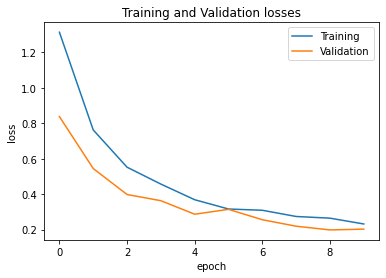

In [23]:
import matplotlib.pyplot as plt

plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation losses')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.savefig( 'loss.jpg', dpi=500, bbox_inches = 'tight')

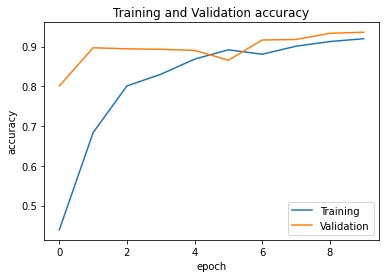

In [24]:
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.legend(['Training', 'Validation'])
plt.title('Training and Validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.savefig( 'accuracy.jpg', dpi=500, bbox_inches = 'tight')

In [32]:
test_images

In [25]:
# Predict
y_pred = best_model.predict(test_images)
y_pred

30/30 [==============================] - 107s 4s/step


array([[8.30284876e-07, 9.82797861e-01, 7.65895835e-20, 8.48581622e-12,
        1.72002781e-02, 1.03878199e-06],
       [9.00188684e-01, 5.96629025e-06, 3.25436758e-07, 3.27123958e-03,
        1.98538671e-03, 9.45484787e-02],
       [3.69314861e-04, 2.05490833e-11, 2.09984351e-02, 9.76051927e-01,
        7.52378284e-08, 2.58020731e-03],
       ...,
       [8.79093766e-01, 2.11739871e-06, 3.08692279e-06, 1.04361065e-02,
        9.83021571e-04, 1.09481931e-01],
       [3.72407271e-07, 9.84328628e-01, 5.40897118e-21, 2.31024965e-12,
        1.56702939e-02, 7.71503039e-07],
       [1.01694150e-06, 1.13924767e-15, 9.45597827e-01, 5.43995723e-02,
        3.73222850e-12, 1.58359626e-06]], dtype=float32)

In [26]:
y_pred = np.argmax(y_pred, axis=1)
y_pred

array([1, 0, 3, 3, 3, 1, 5, 1, 2, 2, 5, 3, 1, 2, 4, 4, 2, 4, 5, 2, 1, 3,
       4, 2, 4, 4, 4, 3, 2, 5, 3, 1, 2, 3, 2, 3, 4, 5, 4, 5, 0, 5, 4, 3,
       1, 4, 1, 4, 1, 0, 2, 2, 0, 3, 2, 0, 5, 0, 4, 0, 3, 5, 2, 5, 3, 0,
       5, 3, 1, 5, 1, 5, 5, 0, 5, 3, 0, 2, 0, 2, 0, 0, 4, 3, 2, 5, 2, 4,
       5, 5, 4, 5, 0, 1, 4, 2, 4, 1, 4, 2, 5, 2, 4, 5, 4, 4, 1, 0, 1, 4,
       2, 4, 4, 5, 2, 2, 2, 3, 3, 3, 0, 2, 4, 0, 1, 3, 4, 1, 4, 5, 4, 5,
       2, 4, 2, 0, 3, 3, 2, 0, 1, 2, 1, 3, 0, 0, 4, 3, 2, 1, 5, 3, 0, 4,
       1, 2, 4, 3, 0, 3, 3, 5, 5, 3, 1, 1, 4, 0, 3, 0, 5, 4, 1, 1, 0, 5,
       2, 5, 0, 2, 5, 0, 1, 3, 4, 4, 4, 1, 4, 2, 1, 4, 3, 4, 4, 4, 0, 0,
       5, 1, 5, 0, 5, 0, 1, 2, 0, 2, 4, 0, 0, 3, 0, 4, 2, 4, 1, 0, 5, 0,
       0, 0, 3, 2, 1, 2, 0, 3, 2, 4, 1, 2, 4, 0, 5, 2, 5, 0, 4, 1, 3, 2,
       4, 4, 0, 5, 0, 3, 2, 3, 2, 4, 2, 3, 4, 4, 3, 3, 0, 5, 4, 0, 2, 1,
       5, 1, 3, 2, 5, 5, 1, 0, 2, 5, 0, 2, 0, 1, 4, 5, 4, 4, 0, 0, 2, 3,
       3, 2, 0, 5, 4, 3, 1, 2, 1, 0, 1, 0, 5, 2, 3,

In [27]:
from sklearn.metrics import confusion_matrix, classification_report


cm = confusion_matrix(test_images.labels, y_pred)
print(cm)

report = classification_report(test_images.labels, y_pred, target_names=['F', 'M', 'N', 'Q', 'S', 'V'],digits=4)
print(report )

def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df
report = report_to_df(report)

report.to_csv('classification report.csv', index=True)

[[149   0   0   1   0  10]
 [  0 135   0   0  25   0]
 [  0   0 160   0   0   0]
 [  0   0   4 156   0   0]
 [  3   2   0   0 155   0]
 [ 17   0   0   5   0 138]]
              precision    recall  f1-score   support

           F     0.8817    0.9313    0.9058       160
           M     0.9854    0.8438    0.9091       160
           N     0.9756    1.0000    0.9877       160
           Q     0.9630    0.9750    0.9689       160
           S     0.8611    0.9688    0.9118       160
           V     0.9324    0.8625    0.8961       160

    accuracy                         0.9302       960
   macro avg     0.9332    0.9302    0.9299       960
weighted avg     0.9332    0.9302    0.9299       960

